In [1]:
from pathlib import Path
import random
import math

import numpy as np
from numba import njit

from matplotlib import pyplot as plt

### Load reference data

In [2]:
img_size = 784
img_shape = (28, 28)

train_data = np.loadtxt(Path(r'D:\Development\Python\jupyter\data\csv\mnist_train_small.csv'), delimiter=',')
test_data = np.loadtxt(Path(r'D:\Development\Python\jupyter\data\csv\mnist_test.csv'), delimiter=',')

### Generate dataset

In [3]:
def one_hot(n_samples: int, idx: int) -> np.ndarray:
    q = np.zeros(n_samples)
    q[idx] = 1.0
    return q

In [4]:
x_train = train_data[:,1:] / 255.0
y_train = np.array([one_hot(10, int(i)) for i in train_data[:,0]])

x_test = test_data[:,1:] / 255.0
y_test = np.array([one_hot(10, int(i)) for i in test_data[:,0]])

In [5]:
mean_x = np.zeros((10, img_size))
count_x = np.zeros(10)

for i in range(x_train.shape[0]):
    j = np.argmax(y_train[i])
    count_x[j] += 1
    mean_x[j] += x_train[i]

mean_x /= count_x.reshape((10, 1))

### Define functions

In [6]:
@njit(fastmath=True)
def norm(x: np.ndarray) -> float:
    return math.sqrt(np.sum(np.square(x)))


@njit(fastmath=True)
def norm_squared(x: np.ndarray) -> float:
    return np.sum(np.square(x))


@njit(fastmath=True)
def cosim(a: np.ndarray, b: np.ndarray) -> float:
    return np.dot(a, b) / (norm(a) * norm(b))


def mcosim(m: np.ndarray, x: np.ndarray) -> np.ndarray:
    return np.dot(m, x) / (np.apply_along_axis(norm, 1, m) * norm(x))


def mmcosim(m: np.ndarray) -> np.ndarray:
    norms = np.apply_along_axis(norm, 1, m)
    return (m @ m.T) / np.outer(norms, norms)

In [7]:
@njit(fastmath=True)
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1.0 / (1.0 + np.exp(-x))


@njit(fastmath=True)
def dsigmoid(x: np.ndarray) -> np.ndarray:
    y = sigmoid(x)
    return y * (1 - y)


@njit(fastmath=True)
def softmax(x: np.ndarray) -> np.ndarray:
    y = np.exp(x)
    return y / np.sum(y)

In [8]:
@njit(fastmath=True)
def binary_entropy(y: np.ndarray) -> float:
    return -np.sum(y * np.log(y) + (1-y) * np.log(1-y))


@njit(fastmath=True)
def entropy(y: np.ndarray) -> float:
    return -np.sum(y * np.log(y))


@njit(fastmath=True)
def binary_cross_entropy(p: np.ndarray, q: np.ndarray) -> float:
    return -np.sum(p * np.log(q) + (1-p) * np.log(1-q))


@njit(fastmath=True)
def cross_entropy(p: np.ndarray, q: np.ndarray) -> float:
    return -np.sum(p * np.log(q))


@njit(fastmath=True)
def kl_divergence(p: np.ndarray, q: np.ndarray) -> float:
    return -np.sum(p * np.log(q/p))

In [9]:
def range_normalize(x: np.ndarray, a: float, b: float) -> np.ndarray:
    return a + (b - a) * (x - np.min(x)) / (np.max(x) - np.min(x))

### Define model

In [10]:
class Perceptron:
    def __init__(self, n_in: int, n_out: int) -> None:
        self.n_in = n_in
        self.n_out = n_out
        
        self.w: np.ndarray = np.random.uniform(-1, 1, (n_out, n_in))
        self.b: np.ndarray = np.zeros(n_out)

    def forward(self, x: np.ndarray) -> np.ndarray:
        return softmax(self.w @ x + self.b)

    def loss(self, X: np.ndarray, Y: np.ndarray) -> float:
        P = np.array([softmax(self.w @ x + self.b) for x in X])
        loss = np.mean(np.array([cross_entropy(y,p) for y,p in zip(Y, P)]))
        return loss

### SGD implementation

In [11]:
@njit(fastmath=True)
def pretrain_grads(x_batch: np.ndarray, w: np.ndarray, b: np.ndarray, rho: float) -> tuple[np.ndarray]:
    dw = np.zeros(w.shape)
    db = np.zeros(b.shape)

    for i in range(x_batch.shape[0]):
        u = w @ x_batch[i] + b

        y = sigmoid(u) # 1

        # y = softmax(u) # 2

        # y = sigmoid(u) # 3
        # p = softmax(y) # 3

        # dLdu = y-1 # 1 (information minimization)
        # dLdu = 10*y - 1 # 2 (information minimization)
        dLdu = -y * (1-y) * np.log((1-y)/y) # 1 (binary entropy)
        # dLdu = -y * (np.sum(y*np.log(y))-np.log(y)) # 2 (entropy)
        # dLdu = -y * (np.sum(y*np.log(y/(1-y))) + np.log((1-y)/y)) # 2 (binary entropy)

        # dLdu = (1-rho)*y - rho*(1-y) # 1/2
        # dLdu += (1-rho)*p - rho*(1-p) # 3
        # dLdu = (1-p)*y - p*(1-y) # 3

        dw += np.outer(dLdu, x_batch[i])
        db += dLdu

    return (dw, db)


@njit(fastmath=True)
def grads(x_batch: np.ndarray, y_batch: np.ndarray, w: np.ndarray, b: np.ndarray) -> tuple[np.ndarray]:
    dw = np.zeros(w.shape)
    db = np.zeros(b.shape)

    for i in range(x_batch.shape[0]):
        y = softmax(w @ x_batch[i] + b)

        dLdz = y - y_batch[i]

        dw += np.outer(dLdz, x_batch[i])
        db += dLdz

    return (dw, db)


def pretrain(model: Perceptron, x_train: np.ndarray, rho, lr, batch_size, max_epoch) -> None:
    n = x_train.shape[0]
    n_batches = n // batch_size

    for epoch in range(max_epoch):
        idxs = np.random.permutation(n)

        for i in range(n_batches):
            ibegin = i * batch_size
            iend = min((i + 1) * batch_size, n - 1)
            batch_idxs = idxs[ibegin:iend]

            dw, db = pretrain_grads(x_train[batch_idxs], model.w, model.b, rho)

            model.w -= lr * dw/batch_size
            model.b -= lr * db/batch_size


def train(model: Perceptron, x_train: np.ndarray, y_train: np.ndarray, lr, batch_size, max_epoch) -> None:
    n = x_train.shape[0]
    n_batches = n // batch_size

    for epoch in range(max_epoch):
        idxs = np.random.permutation(n)

        for i in range(n_batches):
            ibegin = i * batch_size
            iend = min((i + 1) * batch_size, n - 1)
            batch_idxs = idxs[ibegin:iend]

            dw, db = grads(x_train[batch_idxs], y_train[batch_idxs], model.w, model.b)

            model.w -= lr * dw/batch_size
            model.b -= lr * db/batch_size

### Create and train model

In [45]:
n_in = 784
n_out = 10

rho = 1/n_out

model = Perceptron(n_in, n_out)

In [51]:
for i in range(1):
    w_old = model.w.copy()
    b_old = model.b.copy()

    pretrain(model, x_train, rho, 0.1, 256, 4)

    model.w = w_old - model.w
    model.b = b_old - model.b

In [54]:
print(model.loss(x_test, y_test))
train(model, x_train, y_train, 0.1, 64, 4)
print(model.loss(x_test, y_test))

0.3282931188375532
0.30445205163138883


In [43]:
n_true_pos = 0

for x, y in zip(x_test, y_test):
    y_pred = model.forward(x)
    n_true_pos += 1 if np.argmax(y_pred) == np.argmax(y) else 0

accuracy = n_true_pos / x_test.shape[0]
print(f"test set accuracy: {round(accuracy * 100, 2)}%")

test set accuracy: 91.76%


### Visualize weights

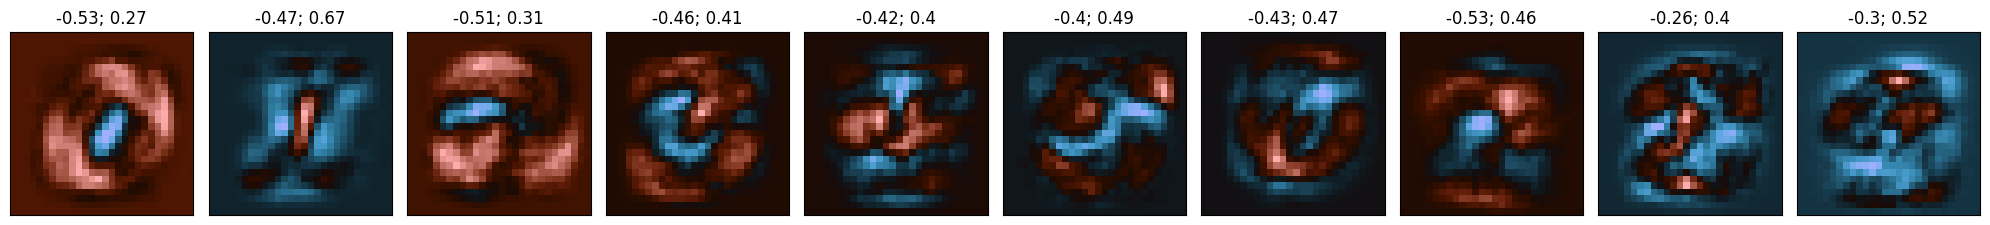

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(100)
fig.set_figwidth(20)
fig.set_figheight(5)

for i, ax in enumerate(axes.ravel()):
    w_norm =  range_normalize(model.w[i], -1, 1)
    img = ax.imshow(w_norm.reshape(img_shape),  cmap='berlin')
    ax.set_title(f"{round(np.min(model.w[i]), 2)}; {round(np.max(model.w[i]), 2)}")
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
plt.show()